# 교과목 연계 IT 역량 강화 프로그램
- 일시: 2026년 1월 20일 (화) 오후 1-3시
- 장소: 26동 101호

## 초보자를 위한 MIMIC-IV 데이터 분석 튜토리얼

이 노트북은 **MIMIC-IV Clinical Database Demo 데이터셋**을 활용하여 파이썬으로 전처리(Preprocessing)와 탐색적 데이터 분석(EDA)을 진행하는 과정을 연습합니다.

### 학습 목표
- CSV 데이터를 `pandas`로 불러오고 구조(컬럼, 타입, 결측치)를 파악한다.
- 시간 데이터(`timestamp`)를 다루고, **재원기간(Length of Stay)** 같은 파생 변수를 만든다.
- 여러 테이블을 **키로 조인(merge)** 하여 분석용 데이터셋을 구성한다.
- 기본적인 집계/시각화로 데이터의 패턴을 확인한다.
- **Sankey Diagram**을 활용하여 병동 간 이동 흐름을 시각화한다.

> 아래는 **질문(텍스트)** → **답 코드** 순서로 구성되어 있습니다. 각 질문을 먼저 읽고, 스스로 어떻게 풀지 떠올린 뒤 코드를 실행해 보세요.

## MIMIC-IV Clinical Database Demo 데이터셋 소개

- **MIMIC-IV(Medical Information Mart for Intensive Care IV)** 는 중환자실(ICU) 중심의 대규모 임상 데이터베이스입니다.
- 이 튜토리얼은 **MIMIC-IV demo** 버전(PhysioNet에서 제공)을 기반으로 합니다.
- demo 데이터셋은 연구/학습 목적의 샘플로, 전체 MIMIC-IV에 비해 규모가 작습니다.

참고: PhysioNet의 MIMIC-IV demo 페이지를 확인하세요: https://physionet.org/content/mimic-iv-demo/2.2/hosp/#files-panel

## 제공 CSV 파일 안내

이번 실습에서는 아래 5개 파일을 사용합니다.

- `patients.csv`: 환자 정보 (인구통계학적 데이터)
- `patient_admissions.csv`: 입원(Admission) 정보 + 주진단 코드
- `patient_discharges.csv`: 퇴원(Discharge) 정보(퇴원/사망 여부 포함)
- `patient_transfers.csv`: 병동/부서 이동(Transfer) 로그
- `d_icd_diagnoses.csv`: ICD 진단 코드 사전(코드 → 진단명)

> 제공 파일은 MIMIC-IV Clinical Database Demo 데이터셋의 일부를 **전처리하여 만든 파일**입니다.

## Colab에서 실행하기

이 노트북을 GitHub에 업로드했다면, **Colab에서 바로 실행**할 수 있습니다.

1) GitHub 저장소에 노트북과 `data/` 폴더(또는 raw 파일 링크)를 준비
2) Colab에서 노트북 열기
3) 아래 셀에서 `BASE_URL`만 내 저장소에 맞게 수정 후 실행

In [36]:
!pip install koreanize-matplotlib

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import plotly.graph_objects as go 
import koreanize_matplotlib #한글 깨지지 않기 위해 사용용

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 데이터 다운로드

GitHub 저장소에서 MIMIC-IV 데이터 파일들을 다운로드하여 Google Drive에 저장합니다.

In [ ]:
# Data download from GitHub to Colab Drive
import os

# Set the data directory path in Google Drive
DATA_PATH = '/content/drive/MyDrive/MIMIC_Data_Analysis/data'

# Create directory if it doesn't exist
os.makedirs(DATA_PATH, exist_ok=True)

print(f"Downloading MIMIC-IV data files to: {DATA_PATH}")

# Download files from GitHub (raw file URLs) to Drive path
# 모든 파일명은 소문자로 통일
!wget -q https://raw.githubusercontent.com/sarahjang15/MIMIC-IV_Data_Analysis/main/data/patients.csv -O {DATA_PATH}/patients.csv
!wget -q https://raw.githubusercontent.com/sarahjang15/MIMIC-IV_Data_Analysis/main/data/patient_admissions.csv -O {DATA_PATH}/patient_admissions.csv
!wget -q https://raw.githubusercontent.com/sarahjang15/MIMIC-IV_Data_Analysis/main/data/patient_discharges.csv -O {DATA_PATH}/patient_discharges.csv
!wget -q https://raw.githubusercontent.com/sarahjang15/MIMIC-IV_Data_Analysis/main/data/patient_transfers.csv -O {DATA_PATH}/patient_transfers.csv
!wget -q https://raw.githubusercontent.com/sarahjang15/MIMIC-IV_Data_Analysis/main/data/d_icd_diagnoses.csv -O {DATA_PATH}/d_icd_diagnoses.csv

print("✓ All data files downloaded successfully!")
print(f"\nData path set to: {DATA_PATH}")

## 1. 데이터 불러오기

### Q1) CSV 파일 불러오기

5개 CSV 파일을 pandas로 불러오고, 각 데이터프레임의 행/열 크기(`shape`)와 컬럼 이름을 확인해보세요.

힌트: `pd.read_csv()`, `.shape`, `.columns`

In [37]:
# CSV 파일 불러오기
patients = pd.read_csv(f'{DATA_PATH}/patients.csv')
admissions = pd.read_csv(f'{DATA_PATH}/patient_admissions.csv')
discharges = pd.read_csv(f'{DATA_PATH}/patient_discharges.csv')
transfers = pd.read_csv(f'{DATA_PATH}/patient_transfers.csv')
d_icd_diagnoses = pd.read_csv(f'{DATA_PATH}/d_icd_diagnoses.csv')

# 각 데이터프레임의 크기 확인
print(f"patients: {patients.shape}")
print(f"admissions: {admissions.shape}")
print(f"discharges: {discharges.shape}")
print(f"transfers: {transfers.shape}")
print(f"d_icd_diagnoses: {d_icd_diagnoses.shape}")

# 컬럼 이름 확인
print("\npatients 컬럼:", list(patients.columns))
print("admissions 컬럼:", list(admissions.columns))
print("discharges 컬럼:", list(discharges.columns))
print("transfers 컬럼:", list(transfers.columns))

patients: (100, 6)
admissions: (275, 5)
discharges: (275, 5)
transfers: (1190, 6)
d_icd_diagnoses: (14567, 4)

patients 컬럼: ['subject_id', 'gender', 'anchor_age', 'anchor_year', 'anchor_year_group', 'dod']
admissions 컬럼: ['patient_id', 'admission_id', 'admission_timestamp', 'urgency_level', 'primary_diagnosis_code']
discharges 컬럼: ['patient_id', 'admission_id', 'admission_timestamp', 'discharge_timestamp', 'discharge_status']
transfers 컬럼: ['patient_id', 'admission_id', 'transfer_type', 'department', 'transfer_in_timestamp', 'transfer_out_timestamp']


### Q2) 데이터 구조 확인

각 테이블의 결측치(NA) 개수와 데이터 타입을 확인해보세요.

힌트: `.info()`, `.isna().sum()`

In [38]:
# 데이터 타입 및 결측치 확인
print("=== patients ===")
patients.info()
print("\n결측치:")
print(patients.isna().sum())

print("\n=== admissions ===")
admissions.info()
print("\n결측치:")
print(admissions.isna().sum())

print("\n=== discharges ===")
discharges.info()
print("\n결측치:")
print(discharges.isna().sum())

print("\n=== transfers ===")
transfers.info()
print("\n결측치:")
print(transfers.isna().sum())

=== patients ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subject_id         100 non-null    int64 
 1   gender             100 non-null    object
 2   anchor_age         100 non-null    int64 
 3   anchor_year        100 non-null    int64 
 4   anchor_year_group  100 non-null    object
 5   dod                31 non-null     object
dtypes: int64(3), object(3)
memory usage: 4.8+ KB

결측치:
subject_id            0
gender                0
anchor_age            0
anchor_year           0
anchor_year_group     0
dod                  69
dtype: int64

=== admissions ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   patient_id              275 non-null    int64 
 1   admiss

## 2. 전처리

### Q3) 환자 데이터 전처리

1. `subject_id`를 문자열로 변환하세요.
2. `gender`의 비율을 계산하세요 (M/F 비율).

힌트: `.astype(str)`, `.value_counts(normalize=True)`

In [39]:
# subject_id를 문자열로 변환
patients['subject_id'] = patients['subject_id'].astype(str)

# gender 비율 계산 (M/F 그대로 유지)
print("성별 분포:")
print(patients['gender'].value_counts())
print("\n성별 비율:")
print(patients['gender'].value_counts(normalize=True))

patients.head()

성별 분포:
gender
M    57
F    43
Name: count, dtype: int64

성별 비율:
gender
M    0.57
F    0.43
Name: proportion, dtype: float64


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10014729,F,21,2125,2011 - 2013,NaN
1,10003400,F,72,2134,2011 - 2013,2137-09-02
2,10002428,F,80,2155,2011 - 2013,NaN
3,10032725,F,38,2143,2011 - 2013,2143-03-30
4,10027445,F,48,2142,2011 - 2013,2146-02-09


### Q4) 입원 데이터 전처리

1. 모든 ID 컬럼(`patient_id`, `admission_id`)을 문자열로 변환하세요.
2. `admission_timestamp`를 datetime 형식으로 변환하세요.
3. `admission_id == "-1"`인 경우를 확인하고 처리하세요.
   - `-1`은 응급실에 갔다가 입원하지 않은 환자들을 의미합니다.
   - 이러한 경우를 필터링하거나 별도로 표시하세요.

힌트: `.astype(str)`, `pd.to_datetime()`, `.query('admission_id != "-1"')`


In [40]:
# 모든 ID 컬럼을 문자열로 변환
admissions['patient_id'] = admissions['patient_id'].astype(str)
admissions['admission_id'] = admissions['admission_id'].astype(str)

# admission_timestamp를 datetime으로 변환
admissions['admission_timestamp'] = pd.to_datetime(admissions['admission_timestamp'])

# admission_id == "-1"인 경우 확인 (응급실 갔다가 입원 안한 환자들)
ed_no_admit = admissions.query('admission_id == "-1"')
print(f"응급실 갔다가 입원 안한 환자: {len(ed_no_admit)}건")
if len(ed_no_admit) > 0:
    print("\n예시:")
    print(ed_no_admit.head())

# 정상적인 입원 ID만 필터링 (선택사항)
# admissions = admissions.query('admission_id != "-1"')

admissions.head()


응급실 갔다가 입원 안한 환자: 0건


,patient_id,admission_id,admission_timestamp,urgency_level,primary_diagnosis_code
0,10004235,24181354,2196-02-24 14:38:00,URGENT,03842
1,10009628,25926192,2153-09-17 17:08:00,URGENT,41401
2,10018081,23983182,2134-08-18 02:02:00,URGENT,99859
3,10006053,22942076,2111-11-13 23:39:00,URGENT,5722
4,10031404,21606243,2113-08-04 18:46:00,URGENT,I308


### Q5) 퇴원 데이터 전처리

1. 모든 ID 컬럼을 문자열로 변환하세요.
2. `discharge_timestamp`, `admission_timestamp` 를 datetime 형식으로 변환하세요.
3. `discharge_status` 분포를 확인하세요.

힌트: `.astype(str)`, `pd.to_datetime()`, `.value_counts()`

In [44]:
# 모든 ID 컬럼을 문자열로 변환
discharges['patient_id'] = discharges['patient_id'].astype(str)
discharges['admission_id'] = discharges['admission_id'].astype(str)

# discharge_timestamp를 datetime으로 변환
discharges['discharge_timestamp'] = pd.to_datetime(discharges['discharge_timestamp'])
discharges['admission_timestamp'] = pd.to_datetime(discharges['admission_timestamp'])

# discharge_status 분포 확인
print("퇴원 상태 분포:")
print(discharges['discharge_status'].value_counts())

discharges.head()

퇴원 상태 분포:
discharge_status
Alive       260
Deceased     15
Name: count, dtype: int64


,patient_id,admission_id,admission_timestamp,discharge_timestamp,discharge_status
0,10004235,24181354,2196-02-24 14:38:00,2196-03-04 14:02:00,Alive
1,10009628,25926192,2153-09-17 17:08:00,2153-09-25 13:20:00,Alive
2,10018081,23983182,2134-08-18 02:02:00,2134-08-23 19:35:00,Alive
3,10006053,22942076,2111-11-13 23:39:00,2111-11-15 17:20:00,Deceased
4,10031404,21606243,2113-08-04 18:46:00,2113-08-06 20:57:00,Alive


### Q6) 전원 데이터 전처리

1. 모든 ID 컬럼을 문자열로 변환하세요.
2. `transfer_in_timestamp`, `transfer_out_timestamp`를 datetime 형식으로 변환하세요.
3. 전원 유형(`transfer_type`) 분포를 확인하세요.

힌트: `.astype(str)`, `pd.to_datetime()`, `.value_counts()`

In [42]:
# 모든 ID 컬럼을 문자열로 변환
transfers['patient_id'] = transfers['patient_id'].astype(str)
transfers['admission_id'] = transfers['admission_id'].astype(str)

# timestamp를 datetime으로 변환
transfers['transfer_in_timestamp'] = pd.to_datetime(transfers['transfer_in_timestamp'])
transfers['transfer_out_timestamp'] = pd.to_datetime(transfers['transfer_out_timestamp'])

# 전원 유형 분포 확인
print("전원 유형 분포:")
print(transfers['transfer_type'].value_counts())

transfers.head()

전원 유형 분포:
transfer_type
transfer     404
discharge    275
admit        275
ED           236
Name: count, dtype: int64


,patient_id,admission_id,transfer_type,department,transfer_in_timestamp,transfer_out_timestamp
0,10009049,22995465,discharge,NaN,2174-05-31 14:21:47,NaT
1,10025612,23403708,discharge,NaN,2125-10-03 12:25:27,NaT
2,10020786,23488445,discharge,NaN,2189-06-13 17:25:44,NaT
3,10014078,25809882,discharge,NaN,2166-08-26 14:49:42,NaT
4,10039831,26924951,discharge,NaN,2116-01-02 14:35:02,NaT


## 3. 파생 변수 생성

### Q7) 재원기간(Length of Stay) 계산

입원 시각과 퇴원 시각의 차이로 재원기간을 계산하세요.

- `los` = `discharge_timestamp` - `admission_timestamp` (일 단위)
- 음수이거나 결측치인 경우가 있는지 확인하세요.
- 히스토그램으로 재원기간 분포를 확인하세요.

힌트: `pd.to_timedelta()`, `.dt.total_seconds() / 86400`, `sns.histplot()`

#### Q7-1) 재원기간 계산

입원 시각과 퇴원 시각의 차이로 재원기간을 계산하세요.

- `los_days` = `discharge_timestamp` - `admission_timestamp` (일 단위로 환산)
- 음수이거나 결측치인 경우가 있는지 확인하세요.


In [47]:
# 재원기간 계산 (일 단위)
discharges['los_days'] = (discharges['discharge_timestamp'] - discharges['admission_timestamp']).dt.total_seconds() / (60*60*24)

# 음수 또는 결측치 확인
print(f"음수 재원기간: {(discharges['los_days'] < 0).sum()}건")
print(f"결측치: {discharges['los_days'].isna().sum()}건")

# 재원기간 통계
print("\n재원기간 통계:")
print(discharges['los_days'].describe())


음수 재원기간: 0건
결측치: 0건

재원기간 통계:
count    275.000000
mean       6.875530
std        6.733832
min        0.046528
25%        2.692014
50%        4.852778
75%        8.768403
max       44.927778
Name: los_days, dtype: float64


#### Q7-2) 재원기간 분포 시각화

재원기간 분포를 히스토그램으로 시각화하세요.


/data/home/seoyeonjang/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



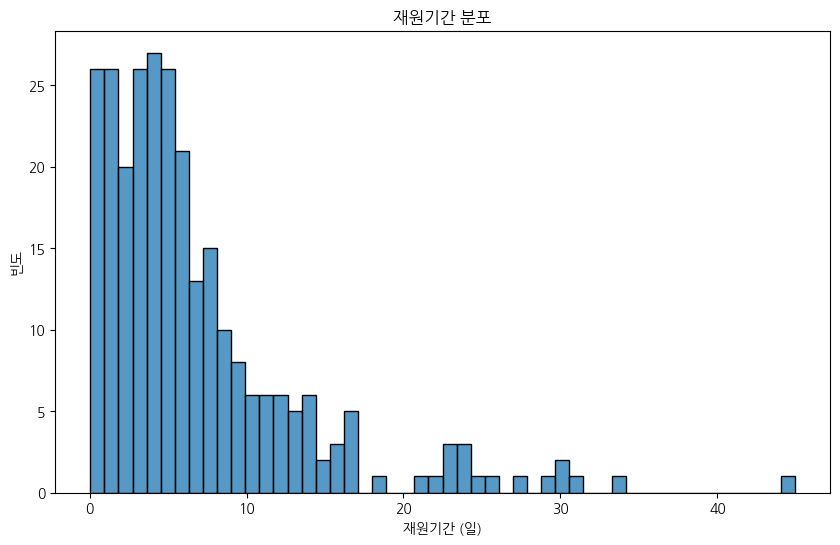

In [48]:
# 재원기간 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(discharges['los_days'], bins=50)
plt.xlabel('재원기간 (일)')
plt.ylabel('빈도')
plt.title('재원기간 분포')
plt.show()


### Q8) 재입원률 계산

각 환자의 입원 기록을 시간순으로 정렬하고, 이전 퇴원일과 다음 입원일 사이의 간격을 계산하여 30일 내 재입원 여부를 판단하세요.

힌트: `.sort_values()`, `.shift(-1)`, `pd.Timedelta(days=30)`

In [49]:
# 각 환자의 입원 기록을 시간순으로 정렬
readmission = admissions.sort_values(by=['patient_id', 'admission_timestamp'], ascending=True)

readmission.head()

,patient_id,admission_id,admission_timestamp,urgency_level,primary_diagnosis_code
18,10000032,22595853,2180-05-06 22:23:00,URGENT,5723
103,10000032,22841357,2180-06-26 18:27:00,EW EMER.,07071
105,10000032,29079034,2180-07-23 12:35:00,EW EMER.,45829
104,10000032,25742920,2180-08-05 23:44:00,EW EMER.,07054
65,10001217,24597018,2157-11-18 22:56:00,EW EMER.,3240


In [50]:
# 환자마다 다음 입원 시각 계산
readmission['next_admit_timestamp'] = readmission.groupby('patient_id')['admission_timestamp'].shift(-1)
readmission.head()

,patient_id,admission_id,admission_timestamp,urgency_level,primary_diagnosis_code,next_admit_timestamp
18,10000032,22595853,2180-05-06 22:23:00,URGENT,5723,2180-06-26 18:27:00
103,10000032,22841357,2180-06-26 18:27:00,EW EMER.,07071,2180-07-23 12:35:00
105,10000032,29079034,2180-07-23 12:35:00,EW EMER.,45829,2180-08-05 23:44:00
104,10000032,25742920,2180-08-05 23:44:00,EW EMER.,07054,NaT
65,10001217,24597018,2157-11-18 22:56:00,EW EMER.,3240,2157-12-18 16:58:00


In [51]:

# 이전 퇴원일과 병합 (discharges와 merge)
readmission = readmission.merge(
    discharges[['admission_id', 'discharge_timestamp']],
    on='admission_id',
    how='left'
)
readmission.head()

,patient_id,admission_id,admission_timestamp,urgency_level,primary_diagnosis_code,next_admit_timestamp,discharge_timestamp
0,10000032,22595853,2180-05-06 22:23:00,URGENT,5723,2180-06-26 18:27:00,2180-05-07 17:15:00
1,10000032,22841357,2180-06-26 18:27:00,EW EMER.,07071,2180-07-23 12:35:00,2180-06-27 18:49:00
2,10000032,29079034,2180-07-23 12:35:00,EW EMER.,45829,2180-08-05 23:44:00,2180-07-25 17:55:00
3,10000032,25742920,2180-08-05 23:44:00,EW EMER.,07054,NaT,2180-08-07 17:50:00
4,10001217,24597018,2157-11-18 22:56:00,EW EMER.,3240,2157-12-18 16:58:00,2157-11-25 18:00:00


In [52]:

# 재입원 간격 계산 (일 단위)
readmission['days_to_readmit'] = (
    readmission['next_admit_timestamp'] - readmission['discharge_timestamp']
).dt.total_seconds() / 86400

readmission.head()

,patient_id,admission_id,admission_timestamp,urgency_level,primary_diagnosis_code,next_admit_timestamp,discharge_timestamp,days_to_readmit
0,10000032,22595853,2180-05-06 22:23:00,URGENT,5723,2180-06-26 18:27:00,2180-05-07 17:15:00,50.050000
1,10000032,22841357,2180-06-26 18:27:00,EW EMER.,07071,2180-07-23 12:35:00,2180-06-27 18:49:00,25.740278
2,10000032,29079034,2180-07-23 12:35:00,EW EMER.,45829,2180-08-05 23:44:00,2180-07-25 17:55:00,11.242361
3,10000032,25742920,2180-08-05 23:44:00,EW EMER.,07054,NaT,2180-08-07 17:50:00,NaN
4,10001217,24597018,2157-11-18 22:56:00,EW EMER.,3240,2157-12-18 16:58:00,2157-11-25 18:00:00,22.956944


In [54]:
# 7일, 30일 내 재입원 여부 계산산
readmission['readmit_7'] = (readmission['days_to_readmit'] <= 7).astype(int)
readmission['readmit_7'] = readmission['readmit_7'].fillna(0).astype(int)
readmission['readmit_30'] = (readmission['days_to_readmit'] <= 30).astype(int)
readmission['readmit_30'] = readmission['readmit_30'].fillna(0).astype(int)


print(f"7일 내 재입원: {readmission['readmit_7'].sum()}건")
print(f"재입원률: {readmission['readmit_7'].mean() * 100:.2f}%")
print(f"30일 내 재입원: {readmission['readmit_30'].sum()}건")
print(f"재입원률: {readmission['readmit_30'].mean() * 100:.2f}%")


7일 내 재입원: 22건
재입원률: 8.00%
30일 내 재입원: 53건
재입원률: 19.27%


### Q9) ICU 방문 여부

`department` 컬럼에 "ICU"라는 문자열이 포함되면 ICU 방문으로 간주하고, `admission_id`별로 ICU 방문 여부를 집계하세요.

힌트: `.str.contains('ICU', na=False)`, `.groupby().any()`

In [55]:
# ICU 방문 여부 확인
transfers['ICU_visit'] = transfers['department'].fillna('').str.contains('ICU', na=False)

# admission_id별 ICU 방문 여부 집계
icu_by_admission = transfers.groupby('admission_id')['ICU_visit'].any().reset_index()
icu_by_admission.columns = ['admission_id', 'icu_visit']
icu_by_admission['icu_visit'] = icu_by_admission['icu_visit'].astype(int)

print(f"ICU 방문한 입원: {icu_by_admission['icu_visit'].sum()}건")
print(f"ICU 방문률: {icu_by_admission['icu_visit'].mean() * 100:.2f}%")

icu_by_admission.head()

ICU 방문한 입원: 120건
ICU 방문률: 43.48%


,admission_id,icu_visit
0,-1,0
1,20044587,1
2,20093566,0
3,20192635,1
4,20199380,1


### Q10) 데이터 병합

`admission_id`를 기준으로 여러 테이블을 병합하여 최종 분석용 데이터셋을 구성하세요.

- `admissions` + `discharges` + `icu_by_admission` (ICU 방문 정보)
- 필요한 컬럼만 선택하여 통합하세요.

힌트: `pd.merge()`, `on='admission_id'`

In [56]:
# 데이터 병합
df_fin = admissions.merge(
    discharges[['admission_id', 'discharge_timestamp', 'discharge_status', 'los_days']],
    on='admission_id',
    how='left'
).merge(
    icu_by_admission,
    on='admission_id',
    how='left'
)

print(f"최종 데이터셋 크기: {df_fin.shape}")
print(f"\n컬럼: {list(df_fin.columns)}")

df_fin.head()

최종 데이터셋 크기: (275, 9)

컬럼: ['patient_id', 'admission_id', 'admission_timestamp', 'urgency_level', 'primary_diagnosis_code', 'discharge_timestamp', 'discharge_status', 'los_days', 'icu_visit']


,patient_id,admission_id,admission_timestamp,urgency_level,primary_diagnosis_code,discharge_timestamp,discharge_status,los_days,icu_visit
0,10004235,24181354,2196-02-24 14:38:00,URGENT,03842,2196-03-04 14:02:00,Alive,8.975000,1
1,10009628,25926192,2153-09-17 17:08:00,URGENT,41401,2153-09-25 13:20:00,Alive,7.841667,1
2,10018081,23983182,2134-08-18 02:02:00,URGENT,99859,2134-08-23 19:35:00,Alive,5.731250,0
3,10006053,22942076,2111-11-13 23:39:00,URGENT,5722,2111-11-15 17:20:00,Deceased,1.736806,1
4,10031404,21606243,2113-08-04 18:46:00,URGENT,I308,2113-08-06 20:57:00,Alive,2.090972,0


## 4. EDA (탐색적 데이터 분석)

### Q11) 환자 정보 분석

1. 성별 분포를 막대 그래프로 시각화하고 비율을 확인하세요.
2. 연령(`anchor_age`) 분포를 히스토그램으로 시각화하세요.
3. 두 그래프를 양 옆에 나란히 한번에 시각화하세요.


힌트: `sns.countplot()`, `sns.histplot()`, `.value_counts(normalize=True)`

/data/home/seoyeonjang/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



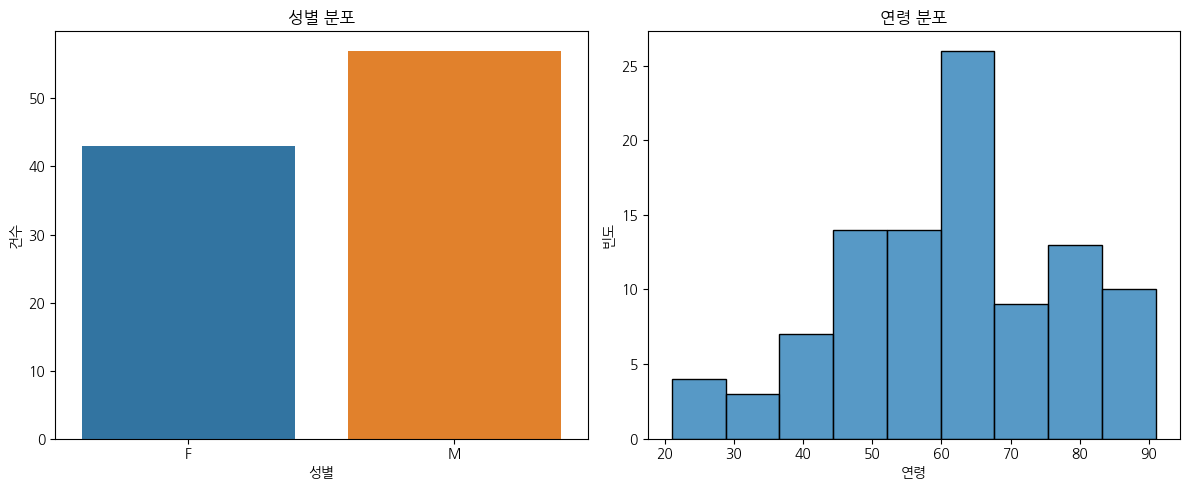

In [59]:
# 성별, 연령 분포 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=patients, x='gender')
plt.title('성별 분포')
plt.xlabel('성별')
plt.ylabel('건수')

plt.subplot(1, 2, 2)
sns.histplot(data=patients, x='anchor_age')
plt.title('연령 분포')
plt.xlabel('연령')
plt.ylabel('빈도')

plt.tight_layout()
plt.show()


### Q12) 입원 응급도 분석

`urgency_level`(입원 유형)의 분포를 확인하고 막대 그래프로 시각화하세요.

힌트: `.value_counts()`, `sns.barplot()`

In [66]:
# 입원 응급도 분포
urgency_counts = admissions['urgency_level'].value_counts()
print("입원 응급도 분포:")
print(urgency_counts)


입원 응급도 분포:
urgency_level
EW EMER.                       104
OBSERVATION ADMIT               45
URGENT                          38
EU OBSERVATION                  30
SURGICAL SAME DAY ADMISSION     18
DIRECT EMER.                    15
ELECTIVE                        13
DIRECT OBSERVATION               7
AMBULATORY OBSERVATION           5
Name: count, dtype: int64


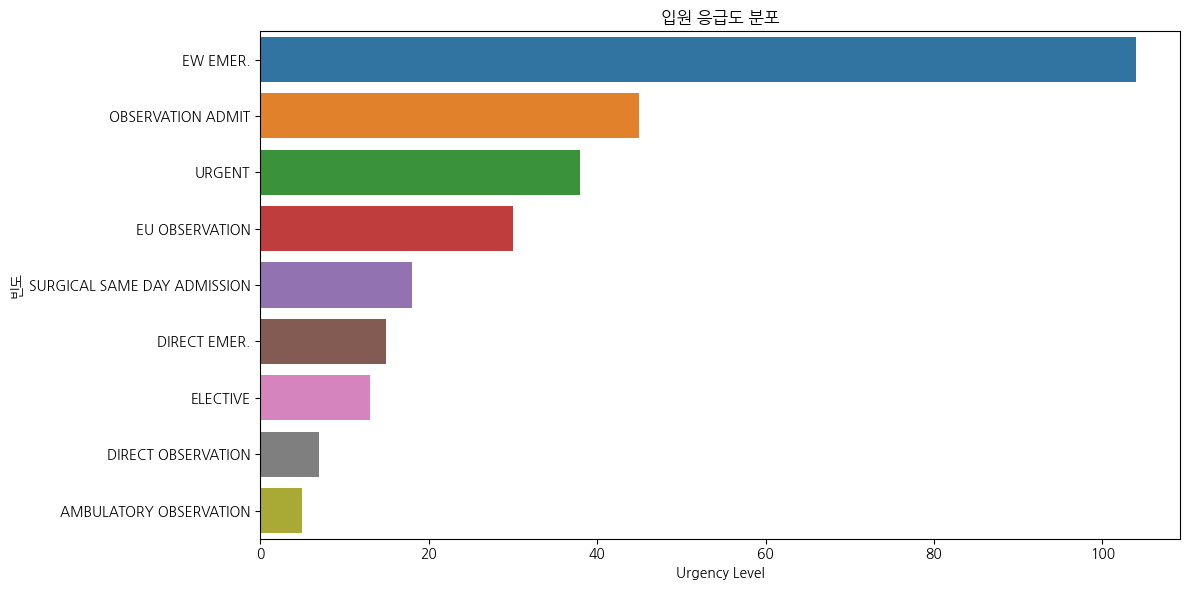

In [ ]:
# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(y=urgency_counts.index, x=urgency_counts.values)
plt.title('입원 응급도 분포')
plt.xlabel('Urgency Level')
plt.ylabel('빈도')
plt.tight_layout()
plt.show()

### Q13) 진단 빈도 분석

1. 주진단 코드(`primary_diagnosis_code`)의 빈도를 계산하세요.
2. `d_icd_diagnoses.csv`와 병합하여 진단명을 확인하세요.
3. 상위 진단 Top 10을 막대 그래프로 시각화하세요.

힌트: `.value_counts()`, `pd.merge()`, `sns.barplot()`

#### Q13-1) 진단 코드 빈도 계산

주진단 코드(`primary_diagnosis_code`)의 빈도를 계산하세요.


In [69]:
# 진단 코드 빈도 계산
diagnosis_counts = admissions['primary_diagnosis_code'].value_counts().head(10).reset_index()
diagnosis_counts.columns = ['primary_diagnosis_code', 'count']

print("상위 10개 진단 코드:")
print(diagnosis_counts)


상위 10개 진단 코드:
  primary_diagnosis_code  count
0                  41401      7
1                   N179      4
2                  99859      4
3                   4241      4
4                   I214      4
5                   A419      3
6                  42731      3
7                  34839      3
8                   5770      3
9                   5849      3


#### Q13-2) 진단명 병합

`d_icd_diagnoses.csv`와 병합하여 진단명을 확인하세요.


In [71]:
# ICD 코드 사전과 병합
icd_code = d_icd_diagnoses.rename(columns={'icd9_code': 'primary_diagnosis_code'})
diagnosis_with_names = diagnosis_counts.merge(
    icd_code[['primary_diagnosis_code', 'long_title']],
    on='primary_diagnosis_code',
    how='left'
)

print("상위 10개 진단 (진단명 포함):")
print(diagnosis_with_names)


상위 10개 진단 (진단명 포함):
  primary_diagnosis_code  count  \
0                  41401      7   
1                   N179      4   
2                  99859      4   
3                   4241      4   
4                   I214      4   
5                   A419      3   
6                  42731      3   
7                  34839      3   
8                   5770      3   
9                   5849      3   

                                          long_title  
0  Coronary atherosclerosis of native coronary ar...  
1                                                NaN  
2                      Other postoperative infection  
3                             Aortic valve disorders  
4                                                NaN  
5                                                NaN  
6                                Atrial fibrillation  
7                               Other encephalopathy  
8                                 Acute pancreatitis  
9                  Acute kidney failure, uns

#### Q13-3) 진단 빈도 시각화

상위 진단 Top 10을 막대 그래프로 시각화하세요.


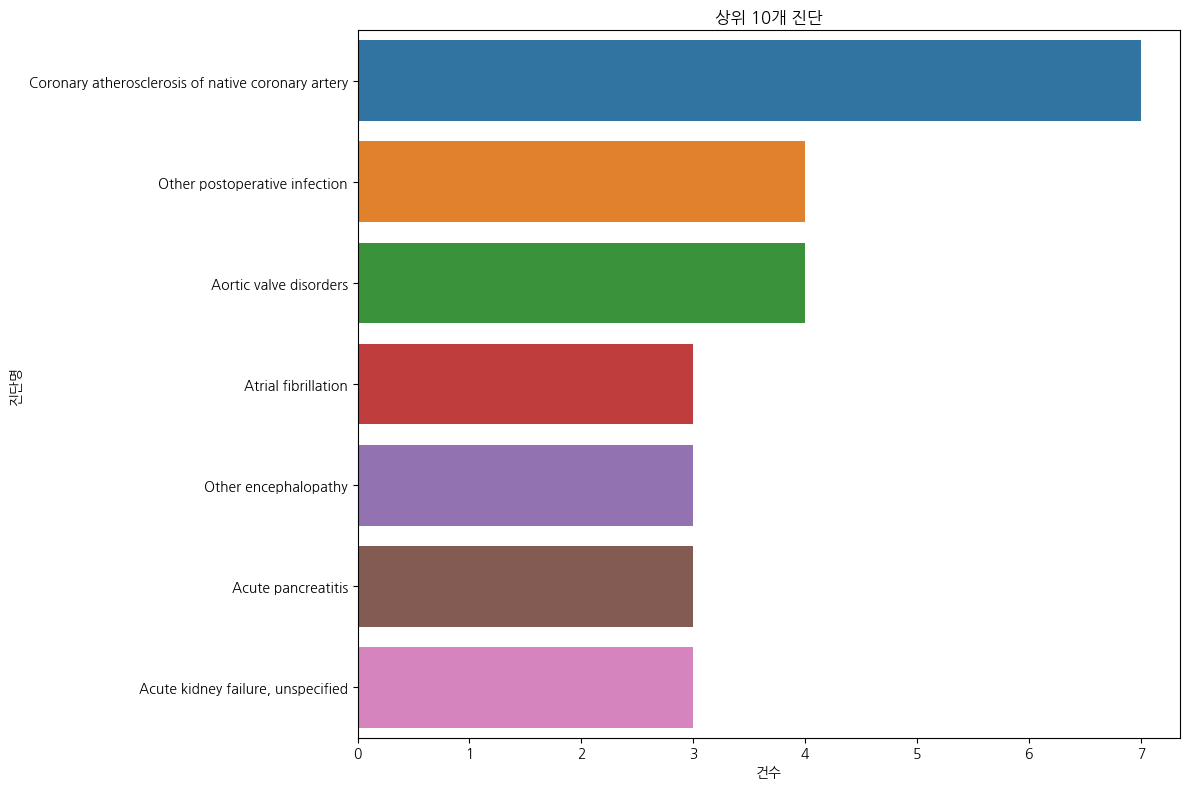

In [72]:
# 시각화
plt.figure(figsize=(12, 8))
sns.barplot(data=diagnosis_with_names, y='long_title', x='count')
plt.title('상위 10개 진단')
plt.xlabel('건수')
plt.ylabel('진단명')
plt.tight_layout()
plt.show()


### Q14) 재원기간 분석

1. 재원기간의 평균, 중앙값, 최빈값을 계산하세요.
2. ICU 방문 여부에 따른 재원기간을 박스 플롯으로 비교하세요.

힌트: `.describe()`, `sns.boxplot()`

#### Q14-1) 재원기간 통계

재원기간의 평균, 중앙값, 최빈값을 계산하세요.


In [76]:
# 재원기간 통계
print("재원기간 통계:")
print(df_fin['los_days'].describe())


재원기간 통계:
count    275.000000
mean       6.875530
std        6.733832
min        0.046528
25%        2.692014
50%        4.852778
75%        8.768403
max       44.927778
Name: los_days, dtype: float64


#### Q14-2) ICU 방문 여부에 따른 재원기간 비교

ICU 방문 여부에 따른 재원기간을 박스 플롯으로 비교하세요.


In [78]:
# 그룹별 평균 재원기간
print("\nICU 방문 여부별 평균 재원기간:")
print(df_fin.groupby('icu_visit')['los_days'].mean())


ICU 방문 여부별 평균 재원기간:
icu_visit
0    5.120856
1    9.141985
Name: los_days, dtype: float64


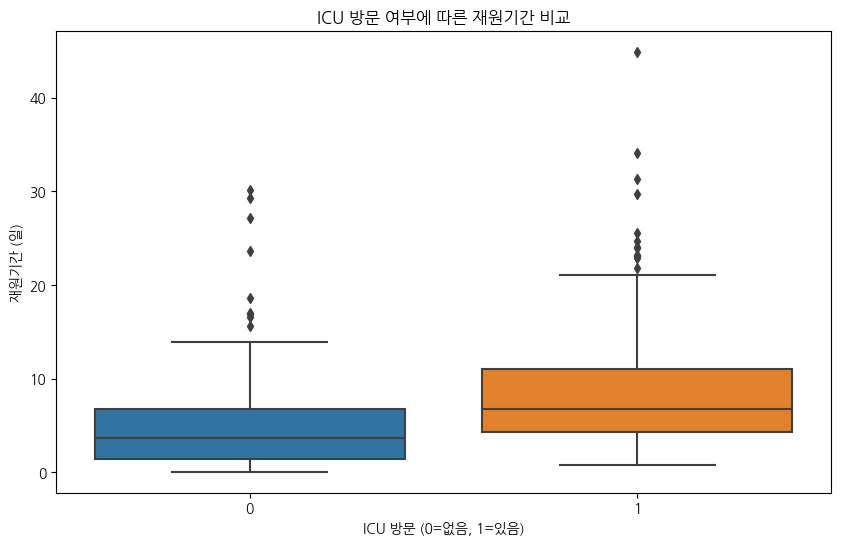

In [79]:
# ICU 방문 여부에 따른 재원기간 비교
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_fin, x='icu_visit', y='los_days')
plt.title('ICU 방문 여부에 따른 재원기간 비교')
plt.xlabel('ICU 방문 (0=없음, 1=있음)')
plt.ylabel('재원기간 (일)')
plt.show()


### Q15) 재입원 분석

1. 재입원 여부 분포를 확인하고 시각화하세요.
2. 재입원 그룹과 비재입원 그룹의 특성을 비교하세요 (예: 평균 재원기간, ICU 방문률).

힌트: `.value_counts()`, `sns.countplot()`, `groupby().mean()`

#### Q15-1) 재입원 여부 분포

재입원 여부 분포를 확인하고 시각화하세요.


In [80]:
# 재입원 여부 분포
readmission_counts = readmission['readmit_30'].value_counts()
print("30일 내 재입원 분포:")
print(readmission_counts)
print(f"\n재입원률: {readmission['readmit_30'].mean() * 100:.2f}%")


30일 내 재입원 분포:
readmit_30
0    222
1     53
Name: count, dtype: int64

재입원률: 19.27%


#### Q15-2) 재입원 그룹 특성 비교

재입원 그룹과 비재입원 그룹의 특성을 비교하세요 (예: 평균 재원기간, ICU 방문률).


In [83]:
# 재입원 그룹과 비재입원 그룹 특성 비교
readmission_merged = readmission.merge(df_fin[['admission_id', 'los_days', 'icu_visit']], on='admission_id', how='left')

print("재입원 그룹별 평균 특성:")
comparison = readmission_merged.groupby('readmit_30').agg({
    'los_days': 'mean',
    'icu_visit': 'mean'
})
print(comparison)


재입원 그룹별 평균 특성:
            los_days  icu_visit
readmit_30                     
0           6.694726   0.445946
1           7.632862   0.396226


### Q16) Department Transfer Flow - Sankey Diagram

**전원(Transfer)이란?**
- 전원은 환자가 입원 기간 동안 병원 내에서 병동/부서 간 이동하는 것을 의미합니다.
- `patient_transfers.csv`에는 각 환자가 어떤 `department`(부서)에서 다른 `department`로 이동한 기록이 시간순으로 저장되어 있습니다.
- 예를 들어, "응급실 → ICU → 일반병동 → 퇴원"과 같은 이동 경로가 기록됩니다.

**Sankey Diagram이란?**
- Sankey Diagram은 흐름(flow)의 양을 화살표의 두께로 표현하는 시각화 기법입니다.
- **Node(노드)**: 각 department (출발지/도착지)
- **Link(링크)**: department 간 이동 (화살표 두께 = 이동 횟수)
- 이를 통해 어떤 병동 간 이동이 가장 빈번한지, 환자 경로(Patient Pathway)가 어떻게 되는지 한눈에 파악할 수 있습니다.

**과제:**
`transfers` 데이터에서 가장 빈도가 높은 Top 10 department 간 이동 경로를 계산하고, Plotly의 `go.Sankey`를 사용하여 시각화하세요.

힌트:
1. 각 `admission_id` 내에서 `transfer_in_timestamp` 기준으로 정렬
2. 연속된 department 쌍 `(dept_i → dept_{i+1})` 생성
3. 각 쌍의 빈도 계산
4. `go.Sankey`의 `node`와 `link` 파라미터 구성

#### Q16-1) 전원 데이터 시간순 정렬

각 `admission_id` 내에서 `transfer_in_timestamp` 기준으로 정렬하세요.


In [87]:
# 각 admission_id 내에서 시간순으로 정렬
transfers_sorted = transfers.query('admission_id != "-1"').sort_values(['admission_id', 'transfer_in_timestamp'])

print(f"정렬된 전원 데이터 크기: {transfers_sorted.shape}")
print("\n정렬 결과 예시 (한 admission_id의 전원 기록):")
example_admission = transfers_sorted['admission_id'].iloc[0]
transfers_sorted[transfers_sorted['admission_id'] == example_admission][['admission_id', 'department', 'transfer_in_timestamp', 'transfer_out_timestamp']].head()


정렬된 전원 데이터 크기: (1136, 7)

정렬 결과 예시 (한 admission_id의 전원 기록):


,admission_id,department,transfer_in_timestamp,transfer_out_timestamp
49,20044587,Discharge Lounge,2113-08-25 03:17:43,2113-08-25 09:32:41
86,20044587,Cardiac Vascular Intensive Care Unit (CVICU),2113-08-25 09:32:41,2113-08-27 16:27:53
44,20044587,Cardiac Surgery,2113-08-27 16:27:53,2113-08-30 14:19:30
15,20044587,NaN,2113-08-30 14:19:30,NaT


#### Q16-2) 연속된 Department 쌍 생성

각 입원 내에서 연속된 department 쌍 `(dept_i → dept_{i+1})`을 생성하세요.

예: "응급실 → ICU → 일반병동"이면 "응급실→ICU", "ICU→일반병동" 두 개의 쌍이 생성됩니다.


In [89]:
# 연속된 department 쌍 생성
transfers_sorted['next_department'] = transfers_sorted.groupby('admission_id')['department'].shift(-1)

# 유효한 이동만 필터링 (department가 있고, 다음 department도 있는 경우)
valid_transfers = transfers_sorted[
    transfers_sorted['department'].notna() & 
    transfers_sorted['next_department'].notna()
].copy()

print(f"유효한 전원 쌍: {len(valid_transfers)}건")
print("\n연속된 department 쌍 예시:")
valid_transfers[['admission_id', 'department', 'next_department']].head(10)


유효한 전원 쌍: 586건

연속된 department 쌍 예시:


,admission_id,department,next_department
49,20044587,Discharge Lounge,Cardiac Vascular Intensive Care Unit (CVICU)
86,20044587,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Surgery
627,20093566,Emergency Department,Medicine
690,20192635,Emergency Department,Medical/Surgical Intensive Care Unit (MICU/SICU)
705,20192635,Medical/Surgical Intensive Care Unit (MICU/SICU),Medicine
591,20199380,Emergency Department,Med/Surg
589,20199380,Med/Surg,Med/Surg
590,20199380,Med/Surg,PACU
588,20199380,PACU,Cardiac Vascular Intensive Care Unit (CVICU)
593,20199380,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU)


#### Q16-3) Department 간 이동 빈도 계산

각 department 쌍의 빈도를 계산하여 이동 흐름을 집계하세요.


In [93]:
# 이동 쌍 빈도 계산
flow_counts = valid_transfers.groupby(['department', 'next_department']).size().reset_index(name='value')

# 전체 이동 빈도 확인
print(f"\n총 이동 횟수: {flow_counts['value'].sum()}건")

# 이동 경로 종류 확인
print(f"총 이동 경로 종류: {len(flow_counts)}개")

# 상위 10개 이동 경로 확인
print("\n상위 10개 이동 경로:")
top10_flow_counts = flow_counts.sort_values('value', ascending=False).head(10)
top10_flow_counts




총 이동 횟수: 586건
총 이동 경로 종류: 167개

상위 10개 이동 경로:


,department,next_department,value
46,Emergency Department,Medicine,25
38,Emergency Department,Emergency Department Observation,24
67,Med/Surg,Med/Surg,19
5,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Surgery,17
125,Neurology,Neurology,17
41,Emergency Department,Med/Surg,14
59,Hematology/Oncology,Hematology/Oncology,13
145,Surgical Intensive Care Unit (SICU),Neurology,13
44,Emergency Department,Medical Intensive Care Unit (MICU),13
105,Medicine,Medicine,13


#### Q16-4) Sankey Diagram 생성

계산한 이동 빈도를 바탕으로 Top 10 이동 경로에 대한 Sankey Diagram을 생성하세요.


In [94]:
# Top 10 이동 경로에 대한 모든 고유 department 목록 생성
all_depts = pd.concat([top10_flow_counts['department'], top10_flow_counts['next_department']]).unique()
dept_to_idx = {dept: idx for idx, dept in enumerate(all_depts)}

# Sankey Diagram 데이터 준비
source = [dept_to_idx[dept] for dept in top10_flow_counts['department']]
target = [dept_to_idx[dept] for dept in top10_flow_counts['next_department']]
value = top10_flow_counts['value'].tolist()

# Sankey Diagram 생성
fig = go.Figure(data=[go.Sankey(
    node=dict(
        label=[str(dept) for dept in all_depts],
        pad=15,
        thickness=20
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
)])

fig.update_layout(title="부서 간 전원 흐름", font_size=10)
fig.show()


# 수고하셨습니다 :)
## 만족도 설문 조사 참여해주세요! (중요)   
https://docs.google.com/forms/d/e/1FAIpQLSdBmMh_nNqdxprdcuO0_KXGl6jCUpOnO0ZHXIewz7KwJD_4Gg/viewform?usp=send_form